<a href="https://colab.research.google.com/github/maheravi/Deep-Learning/blob/main/Recurrent%20Neural%20Network/PyTorch_RNN_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from torch.autograd import Variable

In [2]:
N = 1500
t = np.arange(0,N)

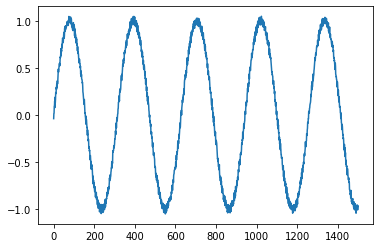

In [3]:
data_sin = np.sin(0.02 * t) + np.random.uniform(-0.05, 0.05, N)
plt.plot(data_sin)

In [4]:
def ConvertSignalToDataset(signal, step):
  X = []
  y = []
  for i in range(len(signal)-step):
    j = i + step
    X.append(signal[i:j])
    y.append(signal[j])

  return np.array(X), np.array(y)

In [5]:
seq_length = 10
x, y = ConvertSignalToDataset(data_sin, seq_length)

In [6]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

In [7]:
dataX = np.array(x)
dataY = np.array(y)

trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])

testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])

In [8]:
trainX.shape

(1192, 10)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_features = torch.Tensor(trainX)
train_targets = torch.Tensor(trainY)
test_features = torch.Tensor(testX)
test_targets = torch.Tensor(testY)

X_train_tensors_final = torch.reshape(train_features,   (train_features.shape[0], 1, train_features.shape[1]))
X_test_tensors_final = torch.reshape(test_features,  (test_features.shape[0], 1, test_features.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, train_targets.shape)
print("Testing Shape", X_test_tensors_final.shape, test_targets.shape) 

train = TensorDataset(X_train_tensors_final, train_targets)
test = TensorDataset(X_test_tensors_final, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

Training Shape torch.Size([1192, 1, 10]) torch.Size([1192])
Testing Shape torch.Size([298, 1, 10]) torch.Size([298])


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=10, hidden_layer_size=64, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [12]:
model = LSTM()
# model = Model()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
print(model)

LSTM(
  (lstm): LSTM(10, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [14]:
epochs = 20

for epoch in range(1, epochs+1):
    train_loss = 0.0
    for X_data, y_data in train_loader:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                    torch.zeros(1, 1, model.hidden_layer_size))
        # 1- forwarding
        preds = model(X_data)
        # 2- backwarding 
        loss = loss_function(preds, y_data)
        loss.backward()
        # 3- Update
        optimizer.step()

        train_loss += loss

    total_loss = train_loss / len(train_loader)

    print(f"Epoch: {epoch}, Loss: {total_loss}")
    # wandb.log({'epochs':  epoch + 1,
    #           'loss': total_loss,
    #           'acc': total_acc
    #                           })

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 0.38000911474227905
Epoch: 2, Loss: 0.06038559973239899
Epoch: 3, Loss: 0.035092055797576904
Epoch: 4, Loss: 0.03447052836418152
Epoch: 5, Loss: 0.035915475338697433
Epoch: 6, Loss: 0.03439027816057205
Epoch: 7, Loss: 0.0372232086956501
Epoch: 8, Loss: 0.03422531113028526
Epoch: 9, Loss: 0.02663120999932289
Epoch: 10, Loss: 0.040713001042604446
Epoch: 11, Loss: 0.060284439474344254
Epoch: 12, Loss: 0.06426369398832321
Epoch: 13, Loss: 0.04077333211898804
Epoch: 14, Loss: 0.027986275032162666
Epoch: 15, Loss: 0.02956726774573326
Epoch: 16, Loss: 0.02525434084236622
Epoch: 17, Loss: 0.025904089212417603
Epoch: 18, Loss: 0.05255153402686119
Epoch: 19, Loss: 0.0382472425699234
Epoch: 20, Loss: 0.02888425998389721


In [22]:
y_pred_train = []
for i in X_train_tensors_final:
  train_predict = model(i)#forward pass
  data_predict = train_predict.data.numpy() #numpy conversion
  y_pred_train.append(data_predict)

y_pred_test = []
for i in X_test_tensors_final:
  test_predict = model(i)#forward pass
  data_predict = test_predict.data.numpy() #numpy conversion
  y_pred_test.append(data_predict)

In [23]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [24]:
len(y_pred_train)

1192

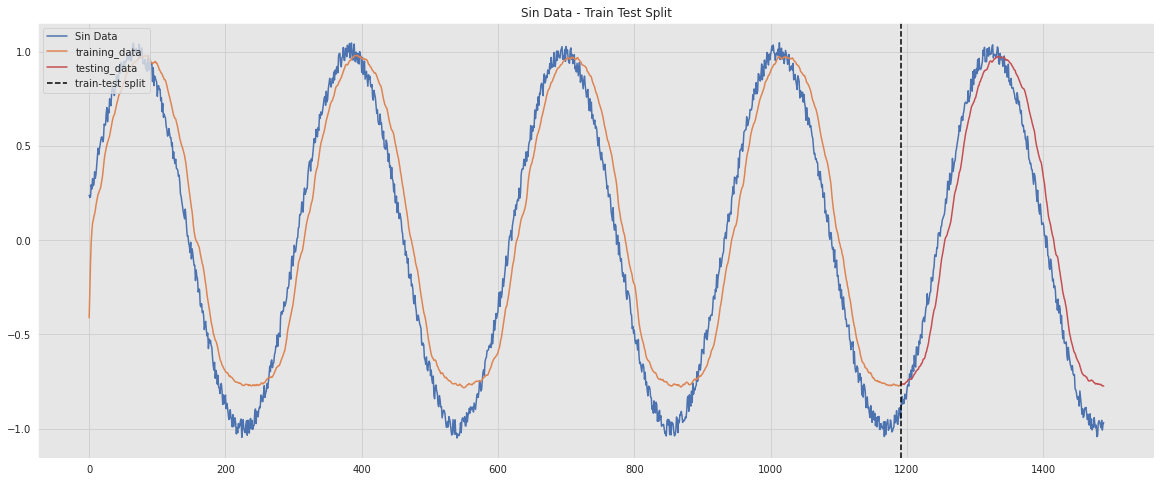

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x=np.arange(0,train_size+test_size),y=np.squeeze(y), color=sns_c[0], label='Sin Data', ax=ax)
sns.lineplot(x=np.arange(0,train_size),y=np.squeeze(y_pred_train), color=sns_c[1], label='training_data', ax=ax)
sns.lineplot(x=train_size+np.arange(0,test_size),y=np.squeeze(y_pred_test), color=sns_c[3], label='testing_data', ax=ax)
ax.axvline(x = train_size, color='black', linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='Sin Data - Train Test Split');